# Imports

In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import seaborn as sns

sns.set()

%matplotlib inline

# Parameters

In [2]:
DATA_FILE = 'Retail.csv'

# Load and clean up data

In [3]:
raw_data = pd.read_csv(DATA_FILE)

In [4]:
raw_data.shape

(84672, 14)

## Standardize column names

Lower case, replace space with underscore

In [5]:
data = raw_data.copy()
data.columns = [c.lower().replace(' ', '_') for c in data.columns]
data = data.rename(columns={'order_method_type': 'channel',
                   'retailer_country': 'country',
                   'product_cost': 'cost', 
                   })
data.head()

,year,product_line,product_type,product,channel,country,revenue,planned_revenue,cost,quantity,unit_cost,unit_price,gross_profit,unit_sale_price
0,2004,Camping Equipment,Cooking Gear,TrailChef Water Bag,Telephone,United States,315044.33,437477.15,158371.76,66385.0,2.552857,6.59,156672.57,5.195714
1,2004,Camping Equipment,Cooking Gear,TrailChef Water Bag,Telephone,Canada,13444.68,14313.48,6298.80,2172.0,2.900000,6.59,7145.88,6.190000
2,2004,Camping Equipment,Cooking Gear,TrailChef Water Bag,Telephone,Mexico,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2004,Camping Equipment,Cooking Gear,TrailChef Water Bag,Telephone,Brazil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2004,Camping Equipment,Cooking Gear,TrailChef Water Bag,Telephone,Japan,181120.24,235236.64,89413.06,35696.0,2.657000,6.59,91707.18,5.488000


# Fix data type

change year to str type, so that they show up nicer in plots

In [6]:
data['year'] = data.year.astype(str)

## Drop invalid rows

This is to confirm all other measures are null when revenue is null

So we can safely drop those rows

Turns out the majority of rows didn't contain valid measures

__Leave them be, the na rows are useful when plotting facetgrid__

In [7]:
data[lambda df: df.revenue.isnull()]\
[['planned_revenue','cost','quantity','unit_cost','unit_price','gross_profit', 'unit_sale_price']]\
.isnull().all()

planned_revenue    True
cost               True
quantity           True
unit_cost          True
unit_price         True
gross_profit       True
unit_sale_price    True
dtype: bool

In [8]:
# data = data.dropna(subset=['revenue'])

In [9]:
data.shape

(84672, 14)

## Add ARPU

Average Revenue per Unit

In [10]:
data['arpu'] = data.revenue / data.quantity

## Figure out some of the columns

Some observations:

- unit_sale_price is always less than or equal to unit_price
- planned_revenue = unit_price * quantity, most of the time
- actual revenue is always less than or equal to planned_revenue
- ARPU is always less than or equal to unit_price
- ARPU is close to unit_sale_price most of the time
- cost = unit_cost * quantity most of the time
- gross_profit = revenue - cost

Conclusions: 

- unit_price and planned_revenue indicates the revenue we should get if selling at full price
- unit_sale_price is most likely the actual recommended selling price at a discounted rate
- ARPU and unit_sale_price is not always consistent, which suggests the actual sales don't always adhere to unit_sale_price

In [11]:
(data.unit_sale_price <= data.unit_price).value_counts()

False    59929
True     24743
dtype: int64

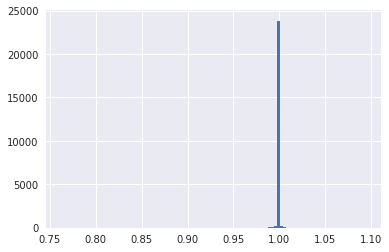

In [12]:
(data.planned_revenue / (data.unit_price * data.quantity)).hist(bins=100)

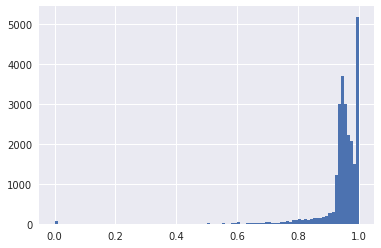

In [13]:
(data.revenue / data.planned_revenue).hist(bins=100)

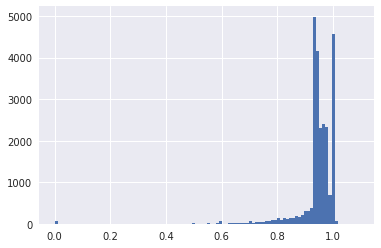

In [14]:
(data.arpu / data.unit_price).hist(bins=100)

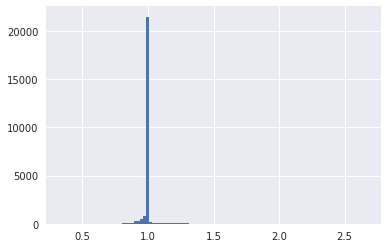

In [15]:
(data.arpu / data.unit_sale_price).hist(bins=100)

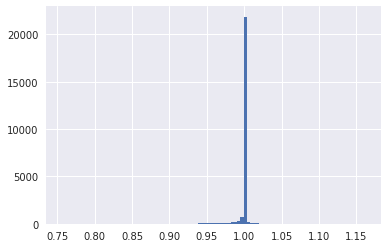

In [16]:
( data.cost / (data.unit_cost * data.quantity) ).hist(bins=100)

In [17]:
( np.round(data.gross_profit, 2) == np.round(data.revenue - data.cost, 2)).all()

False

# Sales reporting

by country, sales channel, product and year

## Validating dimensions

The data looks very clean in terms of categorical values

Product and product_type are too granular for reporting, product_line level seems appropriate

In [18]:
sorted(data.country.unique())

['Australia',
 'Austria',
 'Belgium',
 'Brazil',
 'Canada',
 'China',
 'Denmark',
 'Finland',
 'France',
 'Germany',
 'Italy',
 'Japan',
 'Korea',
 'Mexico',
 'Netherlands',
 'Singapore',
 'Spain',
 'Sweden',
 'Switzerland',
 'United Kingdom',
 'United States']

In [19]:
sorted(data.channel.unique())

['E-mail', 'Fax', 'Mail', 'Sales visit', 'Special', 'Telephone', 'Web']

In [20]:
sorted(data['product'].unique())

['Aloe Relief',
 'Astro Pilot',
 'Auto Pilot',
 'Bear Edge',
 'Bear Survival Edge',
 'Bella',
 'Blue Steel Max Putter',
 'Blue Steel Putter',
 'BugShield Extreme',
 'BugShield Lotion',
 'BugShield Lotion Lite',
 'BugShield Natural',
 'BugShield Spray',
 'Calamine Relief',
 'Canyon Mule Carryall',
 'Canyon Mule Climber Backpack',
 'Canyon Mule Cooler',
 'Canyon Mule Extreme Backpack',
 'Canyon Mule Journey Backpack',
 'Canyon Mule Weekender Backpack',
 'Capri',
 'Cat Eye',
 'Compact Relief Kit',
 'Course Pro Gloves',
 'Course Pro Golf Bag',
 'Course Pro Golf and Tee Set',
 'Course Pro Putter',
 'Course Pro Umbrella',
 'Dante',
 'Deluxe Family Relief Kit',
 'Double Edge',
 'Edge Extreme',
 'EverGlow Butane',
 'EverGlow Double',
 'EverGlow Kerosene',
 'EverGlow Lamp',
 'EverGlow Single',
 'Fairway',
 'Firefly 2',
 'Firefly 4',
 'Firefly Charger',
 'Firefly Climbing Lamp',
 'Firefly Extreme',
 'Firefly Lite',
 'Firefly Mapreader',
 'Firefly Multi-light',
 'Firefly Rechargeable Battery',
 '

In [21]:
sorted(data['product_line'].unique())

['Camping Equipment',
 'Golf Equipment',
 'Mountaineering Equipment',
 'Outdoor Protection',
 'Personal Accessories']

In [22]:
sorted(data['product_type'].unique())

['Binoculars',
 'Climbing Accessories',
 'Cooking Gear',
 'Eyewear',
 'First Aid',
 'Golf Accessories',
 'Insect Repellents',
 'Irons',
 'Knives',
 'Lanterns',
 'Navigation',
 'Packs',
 'Putters',
 'Rope',
 'Safety',
 'Sleeping Bags',
 'Sunscreen',
 'Tents',
 'Tools',
 'Watches',
 'Woods']

## Visualising

The default matplotlib theme doesn't fit well with financial reporting conventions, but I won't put too much effort into formatting since it would take too much time. 

## Total revenue, cost, gross_profit over years

More than 1 billion revenue per year, what ever currency it is in, it's surely good business

Margin % has been relatively stable over the years, saw a small lift from 40.2% to 41.6% from 2004 to 2007

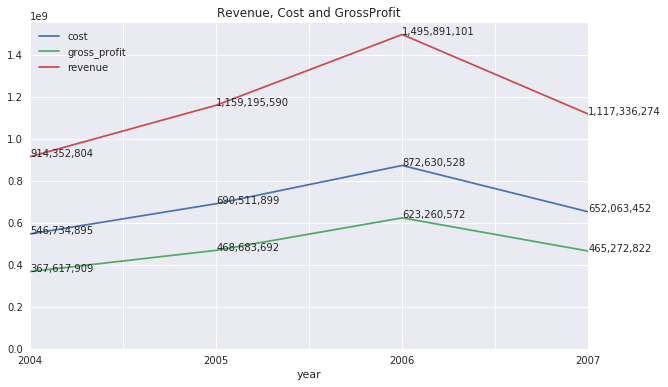

In [23]:
rcm_by_year = data.pivot_table(index='year', values=['revenue','cost','gross_profit'], aggfunc='sum')

def line_plot_multi_cols(data: pd.DataFrame, title: str, 
                         ylim: tuple = (None, None), 
                        label_format: str = '{:,.0f}'):
    ax = data.plot(ylim=ylim, figsize=(10,6), title=title)

    for i, row_tuple in enumerate(data.iterrows()):
        idx = row_tuple[0]
        row = row_tuple[1]
        for col, val in row.iteritems():
            ax.annotate(label_format.format(val), (i, val))
            
line_plot_multi_cols(rcm_by_year, 'Revenue, Cost and GrossProfit', ylim=(0, None))

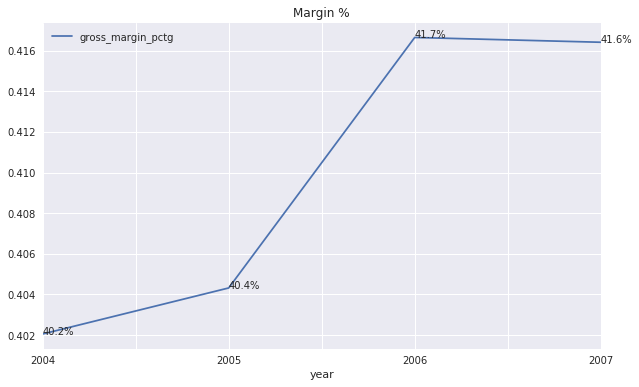

In [24]:
margin_pct = rcm_by_year.assign(gross_margin_pctg=lambda df: df.gross_profit / df.revenue)[['gross_margin_pctg']]

line_plot_multi_cols(margin_pct, 'Margin %', label_format='{:.1%}')

### Revenue by Country

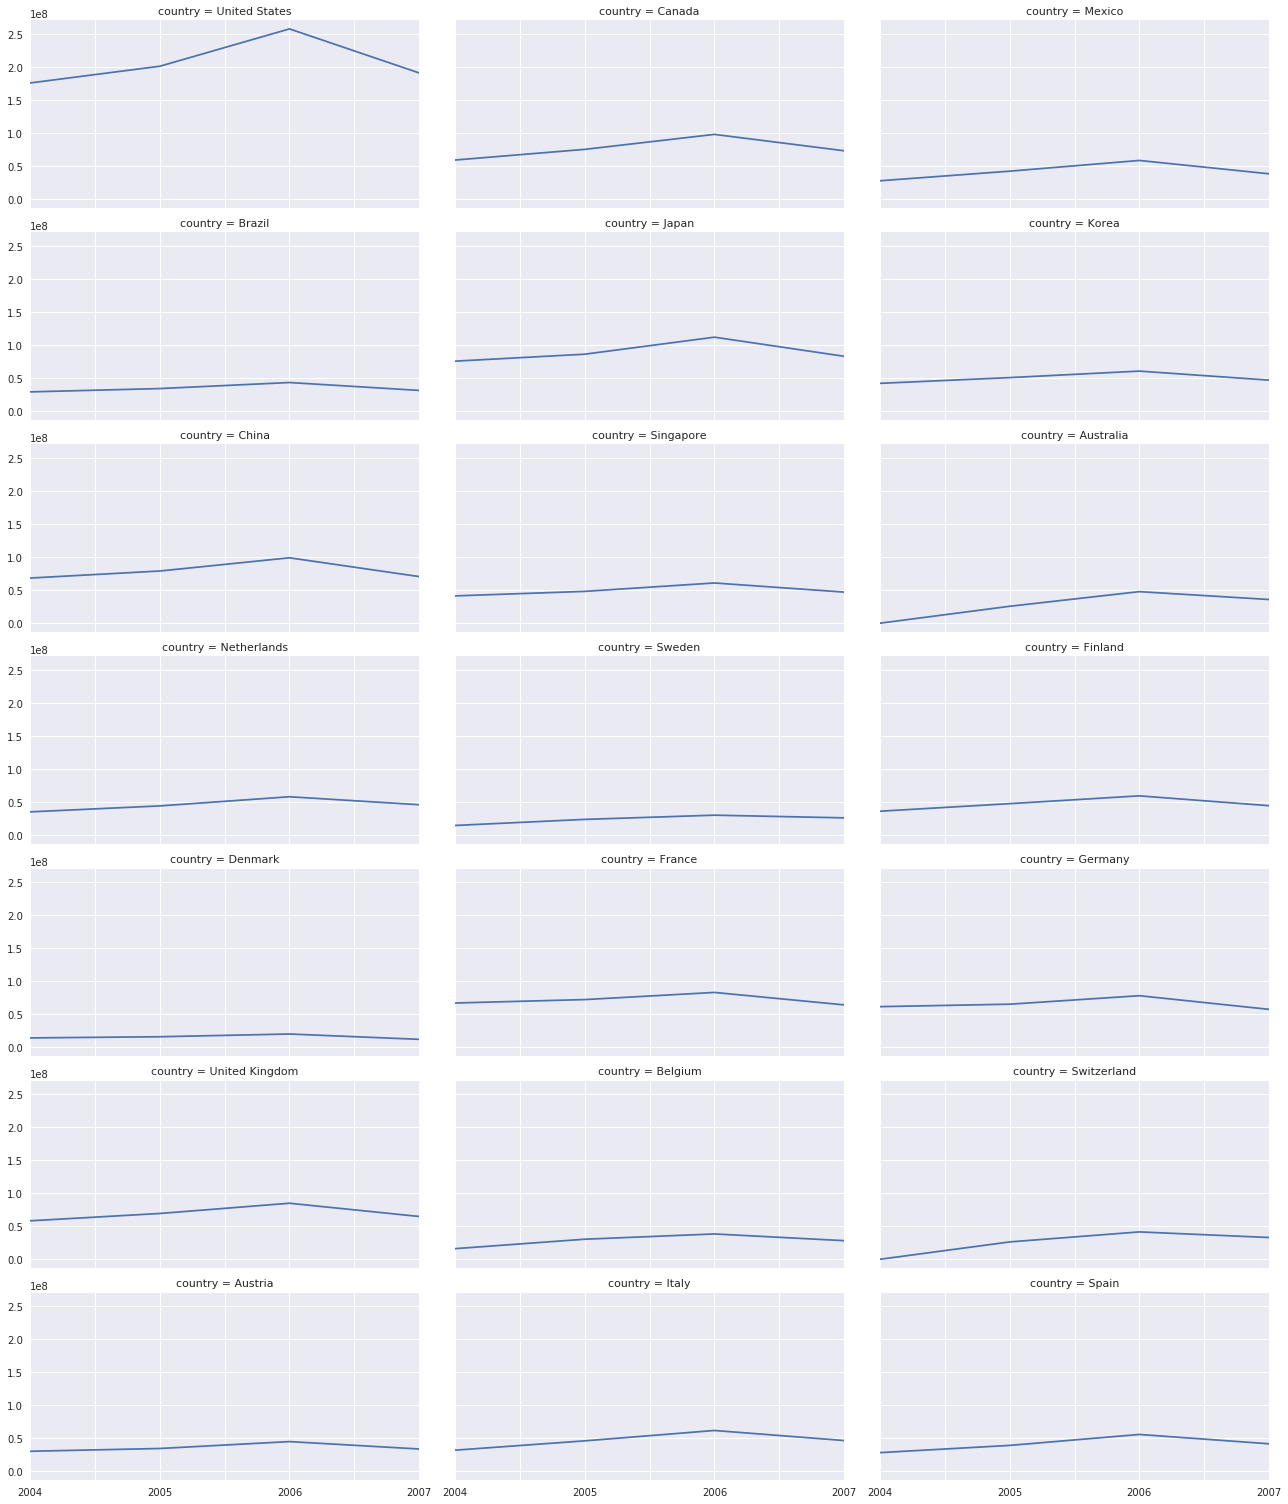

In [26]:
g = sns.FacetGrid(data, col='country', col_wrap=3, sharey=True, sharex=True, aspect=2, dropna=False)

def plot_revenue_line(**kwargs):
    ax_data = kwargs['data']
    ax_data.pivot_table(index='year', values='revenue', aggfunc='sum')\
    .plot(ax=plt.gca())

g.map_dataframe(plot_revenue_line)

plt.tight_layout()

### Revenue by Channel

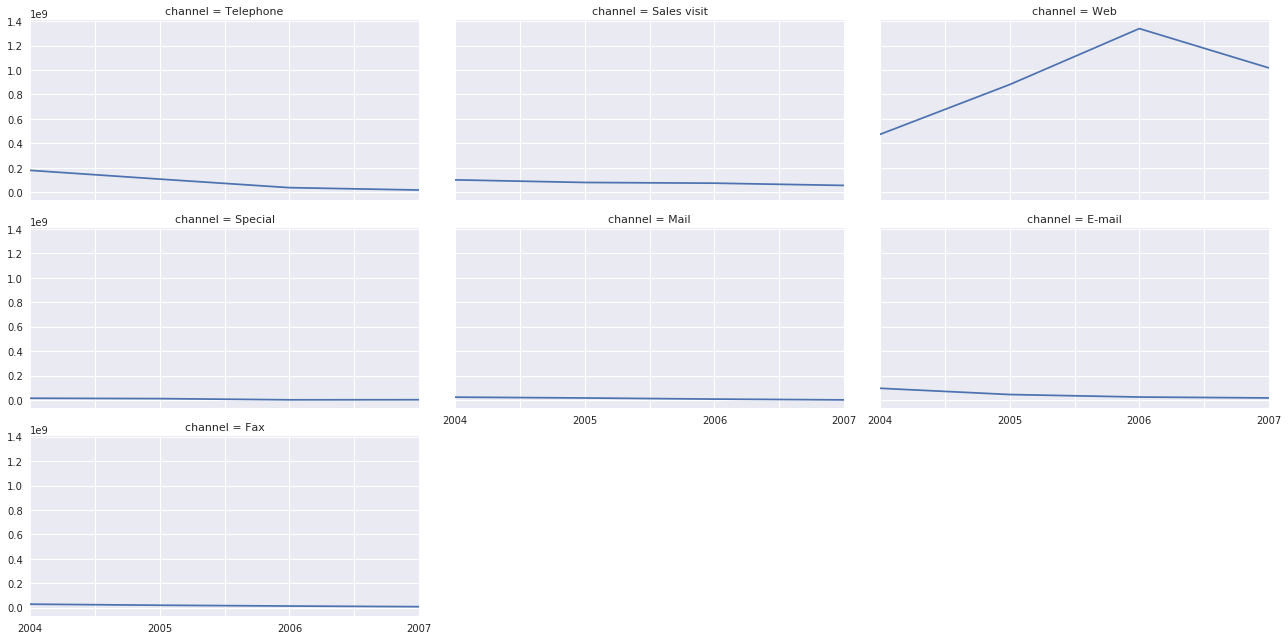

In [30]:
g = sns.FacetGrid(data, col='channel', col_wrap=3, sharey=True, sharex=True, aspect=2, dropna=False)
g.map_dataframe(plot_revenue_line)
plt.tight_layout()

### Revenue by ProductLine

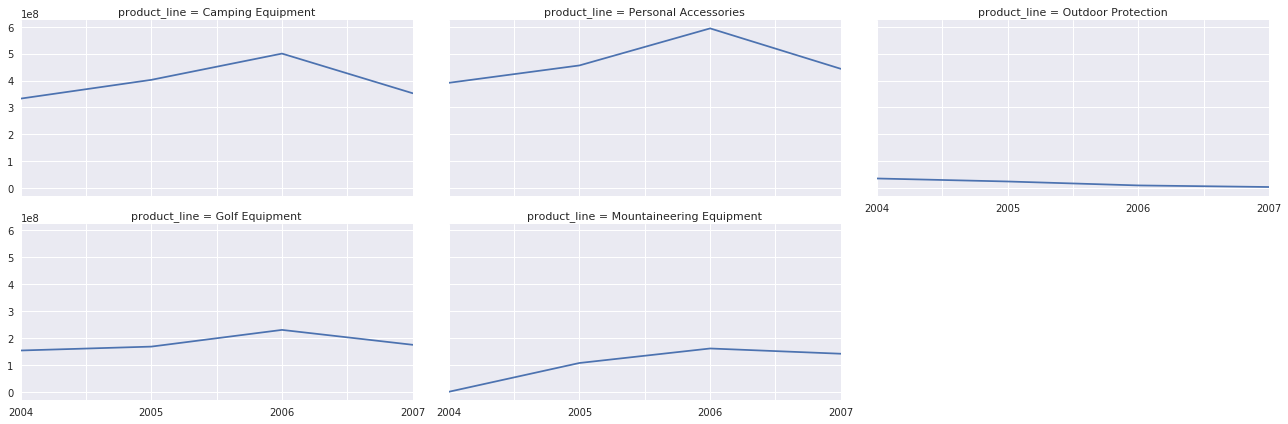

In [28]:
g = sns.FacetGrid(data, col='product_line', col_wrap=3, sharey=True, sharex=True, aspect=2, dropna=False)
g.map_dataframe(plot_revenue_line)
plt.tight_layout()

# Recommendations for improving profit

Profit is a function of Revenue and Cost/Margin. 
And revenue can be influenced by UnitPrice and Quantity. 

The obvious safe choice is: 
1. Increase Quantity by riding the upwards trends
2. Drive down cost whenever possible

Playing with UnitPrice is generally riskier unless we can anticipate the market reaction. 

Following this line of thoughts, we should zoom into the Quantity and Margin % of each country, channel and product to find clues

## Revenue and Margin

### By Country

Margin % have been stable across all countries

Declines have been seen in several high revenue countries, the YoY drop in US is the most significant, worth investigating. 

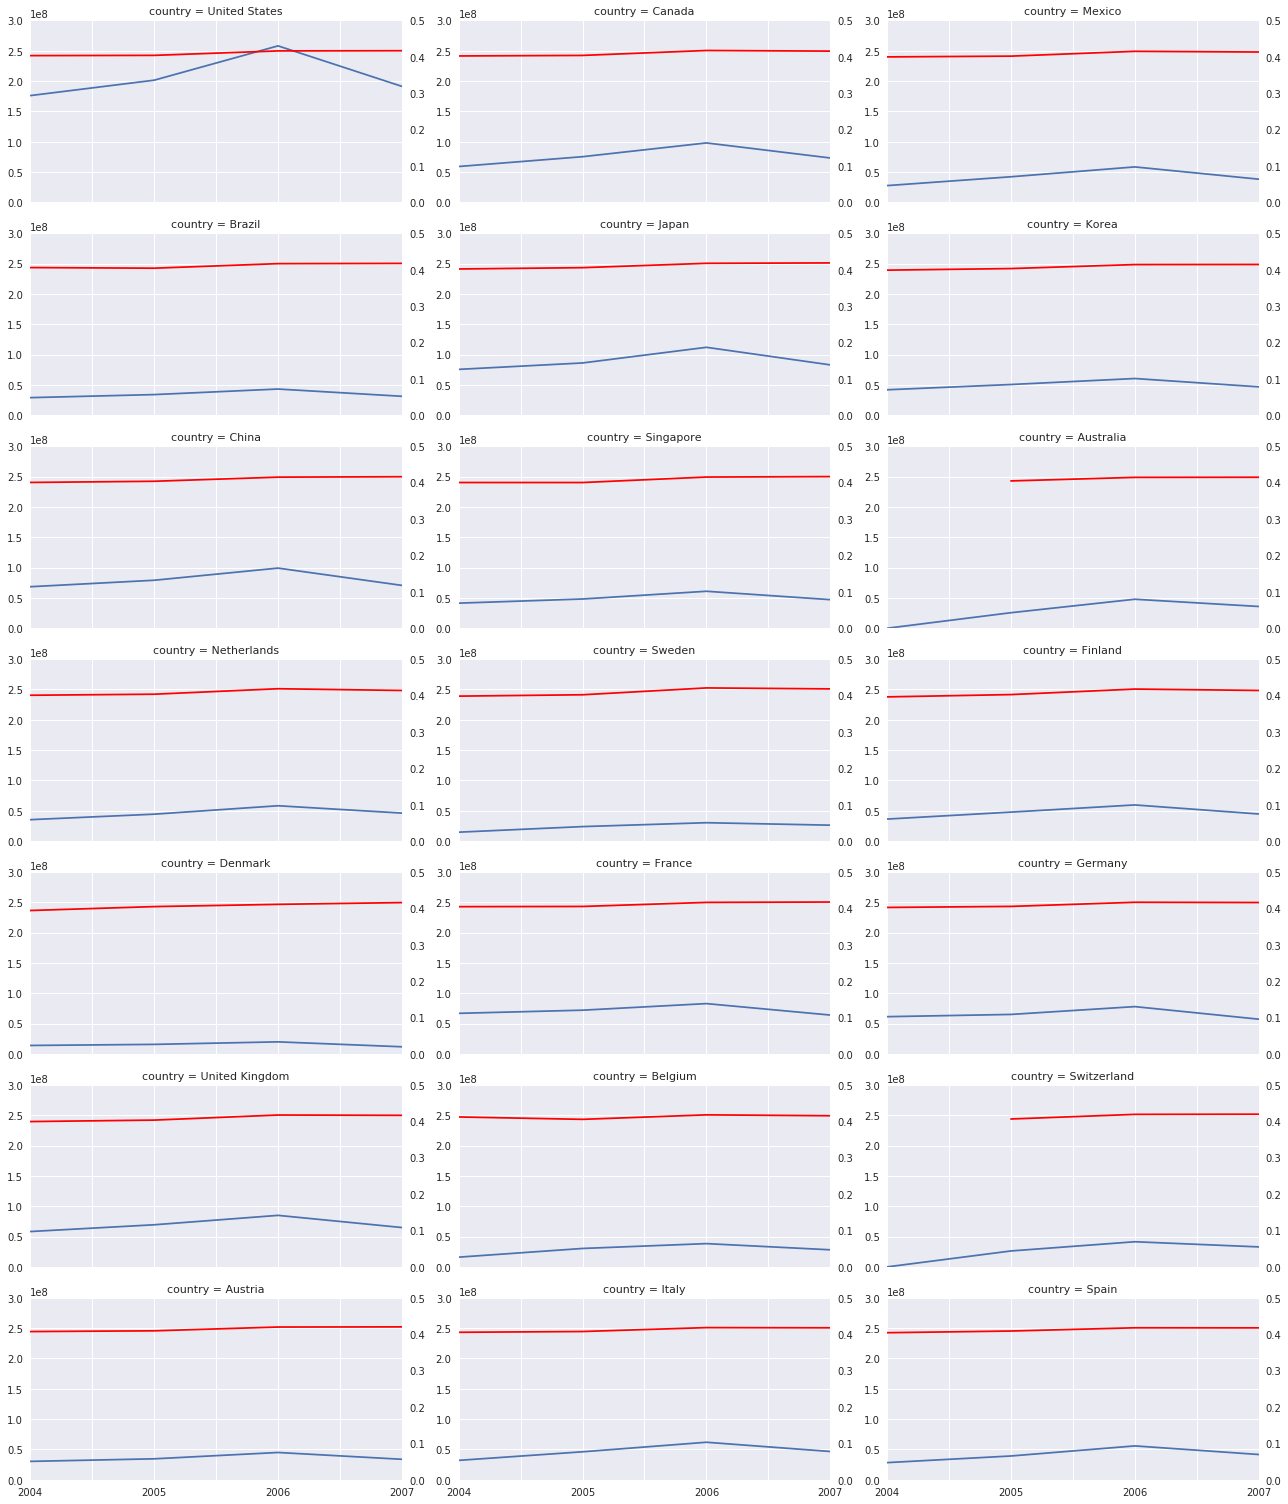

In [68]:
def plot_revenue_margin_pctg(**kwargs):
    ax_data = kwargs['data']
    ylim1 = kwargs['ylim1']
    ylim2 = kwargs['ylim2']
    quantity = ax_data.pivot_table(index='year', values='revenue', aggfunc='sum')
    margin_pctg = ax_data.pivot_table(index='year', values=['revenue','gross_profit'], aggfunc='sum')\
                .assign(margin_pctg=lambda df: df.gross_profit / df.revenue)['margin_pctg']
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    quantity.plot(ax=ax1, ylim=ylim1)
    margin_pctg.plot(ax=ax2, grid=False, cmap='autumn', ylim=ylim2)

g = sns.FacetGrid(data, col='country', col_wrap=3, sharey=False, sharex=True, aspect=2, dropna=False)

g.map_dataframe(plot_revenue_margin_pctg, ylim1=(0, 3e8), ylim2=(0, 0.5))

plt.tight_layout()

### By channel

Web channel has seen the highest YoY decline, given that it contributes to the vast majority of the revenue, we should invest most of our resource into lifting Web channel

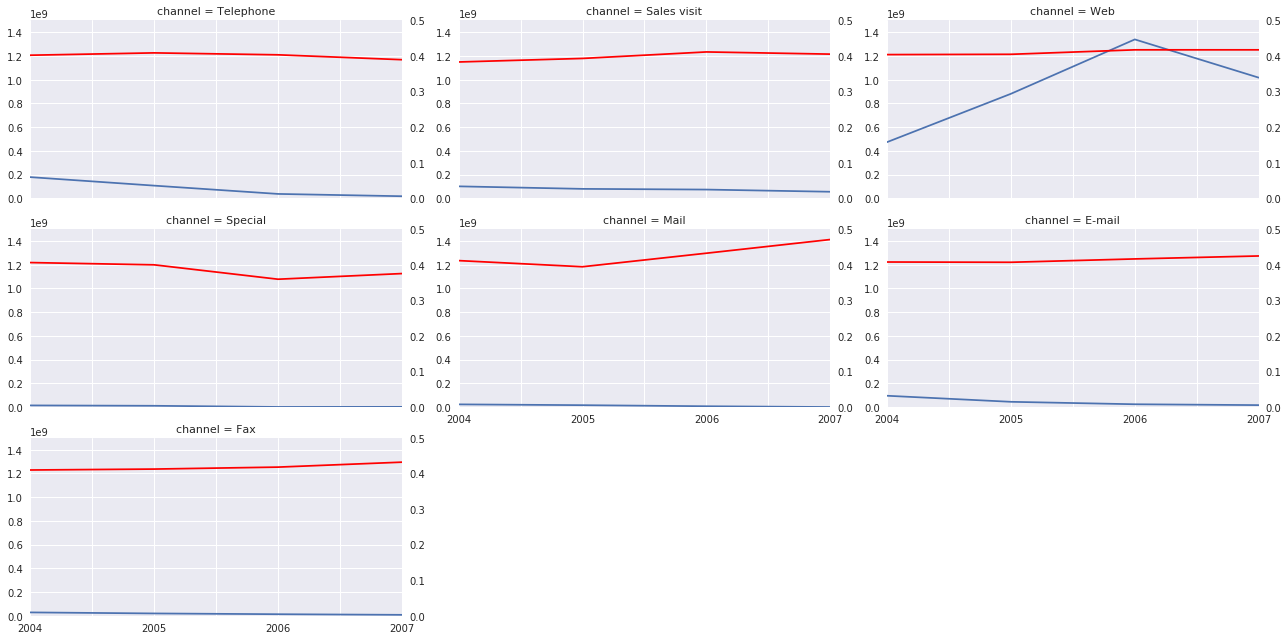

In [71]:
g = sns.FacetGrid(data, col='channel', col_wrap=3, sharey=False, sharex=False, aspect=2, dropna=False)
g.map_dataframe(plot_revenue_margin_pctg, ylim1=(0, 1.5e9), ylim2=(0, 0.5))
plt.tight_layout()

### By Product Line

Mountaineering Equipment has seen growth, opportunity?

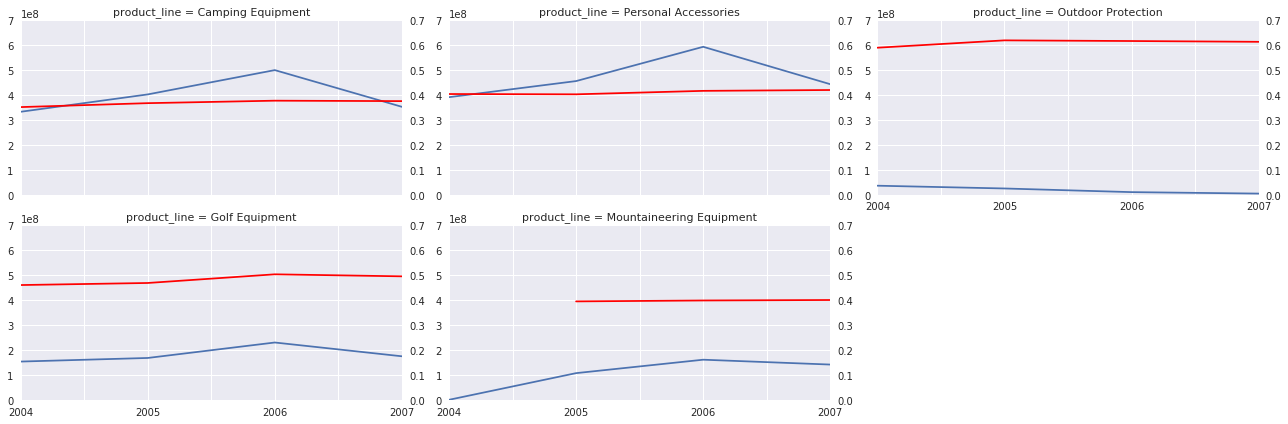

In [73]:
g = sns.FacetGrid(data, col='product_line', col_wrap=3, sharey=False, sharex=True, aspect=2, dropna=False)
g.map_dataframe(plot_revenue_margin_pctg, ylim1=(0, 7e8), ylim2=(0, 0.7))
plt.tight_layout()

## Quantity and Price

### By country

In several countries (US, UK, Japan, Korea), quantity drop has been observed to conincide with price increase, should consider reducing price in those markets. 

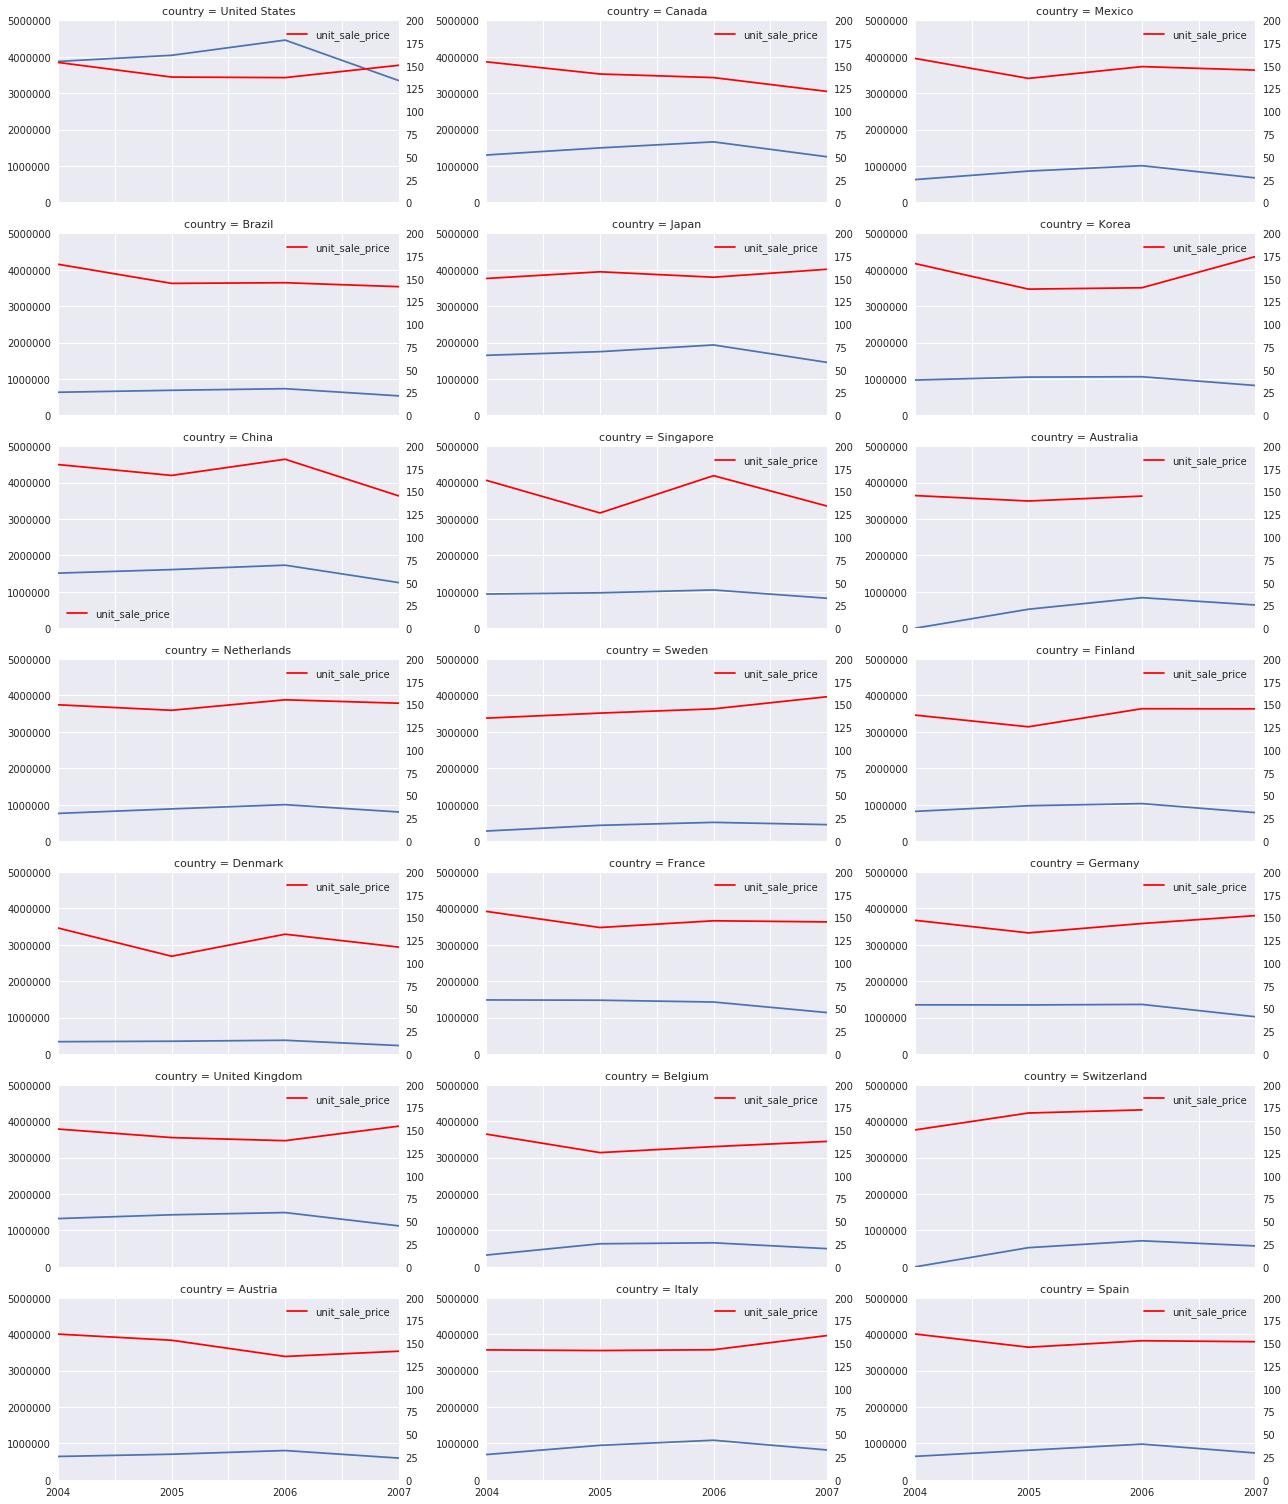

In [47]:
def plot_quantity_price(**kwargs):
    ax_data = kwargs['data']
    ylim1 = kwargs['ylim1']
    ylim2 = kwargs['ylim2']
    quantity = ax_data.pivot_table(index='year', values='quantity', aggfunc='sum')
    unit_sale_price = ax_data.pivot_table(index='year', values='unit_sale_price', aggfunc='mean')
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    quantity.plot(ax=ax1, ylim=ylim1)
    unit_sale_price.plot(ax=ax2, grid=False, cmap='autumn', ylim=ylim2)

g = sns.FacetGrid(data, col='country', col_wrap=3, sharey=False, sharex=True, aspect=2, dropna=False)

g.map_dataframe(plot_quantity_price, ylim1=(0, 5000000), ylim2=(0, 200))

plt.tight_layout()

### By channel

The dominant channel Web's price is largely flat

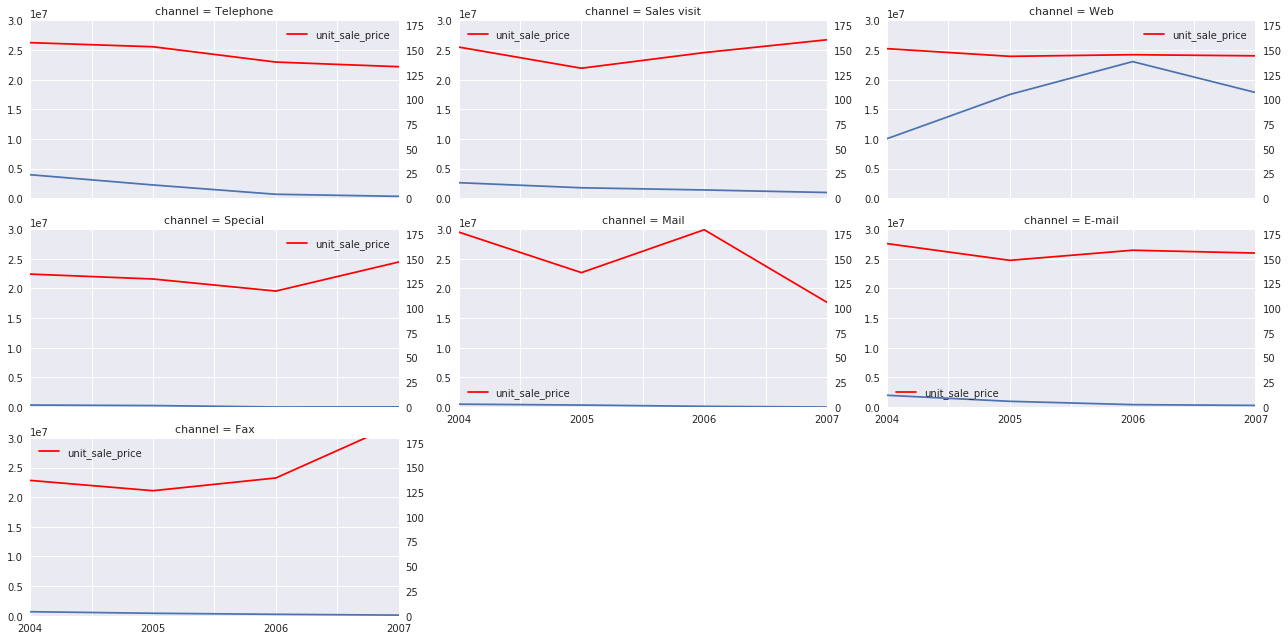

In [61]:
g = sns.FacetGrid(data, col='channel', col_wrap=3, sharey=False, sharex=True, aspect=2, dropna=False)

g.map_dataframe(plot_quantity_price, ylim1=(0, 3e7), ylim2=(0, 180))

plt.tight_layout()

### By product line

Again Outdoor Protection products has seen a big decline over years, its price seems to be very low. In summary it's (used to be) a high volume, low price, high margin product, consider wholesale model?

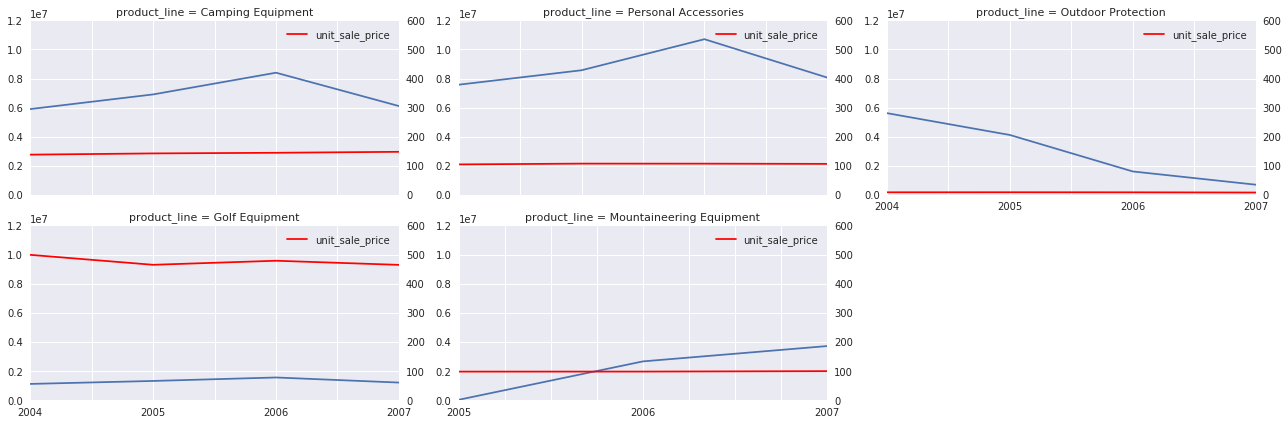

In [64]:
g = sns.FacetGrid(data, col='product_line', col_wrap=3, sharey=False, sharex=False, aspect=2, dropna=False)

g.map_dataframe(plot_quantity_price, ylim1=(0, 1.2e7), ylim2=(0, 600))

plt.tight_layout()

## Country and product line in 2007

Mostly similar, except Demmark really doesn't like mountaineering and golf

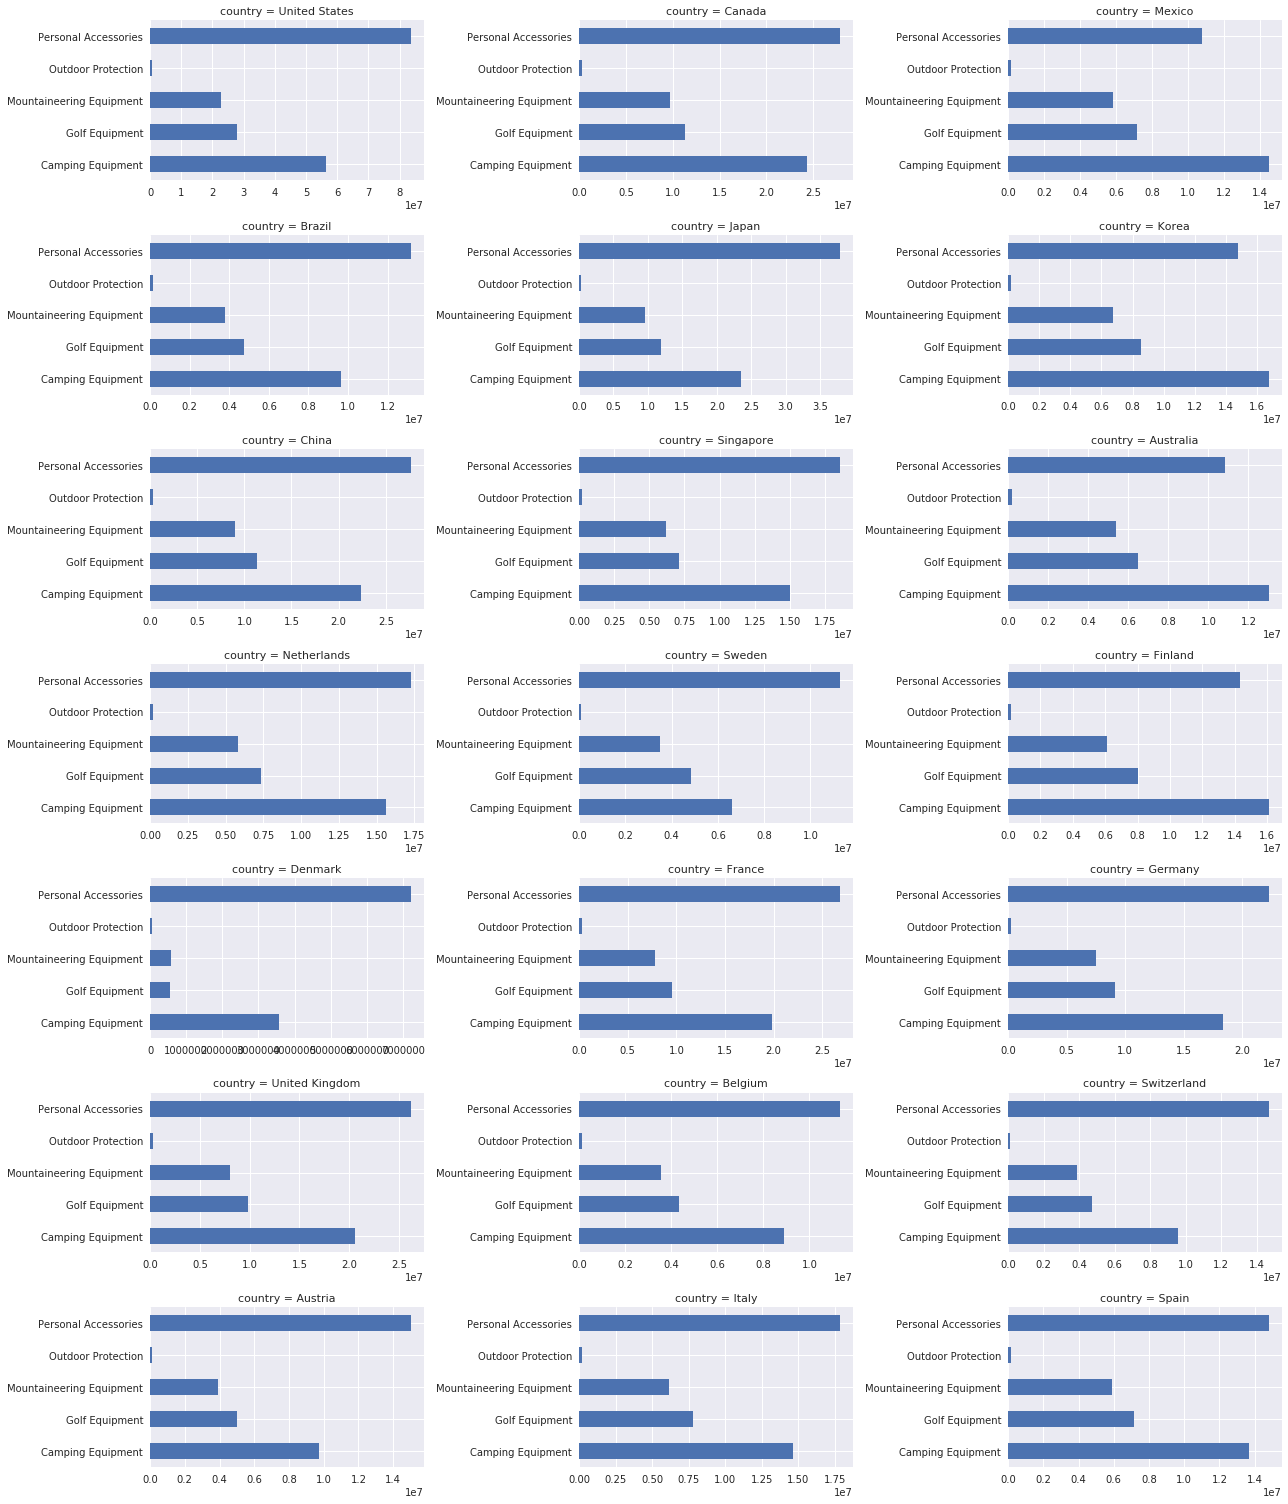

In [81]:
def plot_product_revenue(**kwargs):
    ax_data = kwargs['data']
    product_revenue = ax_data.pivot_table(index='product_line', values='revenue', aggfunc='sum')
    ax1 = plt.gca()
    product_revenue.plot.barh(ax=ax1)

g = sns.FacetGrid(data[lambda df: (df.year=='2007')], 
                  col='country', col_wrap=3, sharey=False, sharex=False, aspect=2.0, dropna=False)

g.map_dataframe(plot_product_revenue)

plt.tight_layout()

## Summary

- Focus on US market Web channel
- Consider reducing price back to 2006 level
- Can we keep growing Mountaineering Equipment line?
- Tailor the product offerings per each country

# Forecasting

In this dataset, the only features that affect sales (revenue) are quantity and ARPU (Average Revenue per Unit). Good explainability is important for sales forecasting model. To give the business more transparency and control over the model, I believe it's best to forecast at the granularity of Country/Channel/Product. 

When it comes to time series forecasting, 4 data points (4 years) are too few for any sophisticated model. In this case, I think the best approach is to assume ARPU stays the same as 2007, and do simple linear extrapolations on quantity. 

In [88]:
qty_hist = data.pivot_table(index=['country','channel','product'], columns='year', values='quantity', aggfunc='sum')

In [100]:
qty_hist.sample(20).assign(**{'2008': np.NaN}).interpolate('linear', axis=1, limit_direction='forward')

,,year,2004,2005,2006,2007,2008
country,channel,product,,,,,
Austria,Mail,Granite Signal Mirror,0.0,0.0,0.0,0.0,0.0
United Kingdom,Sales visit,BugShield Extreme,0.0,3019.0,2754.0,713.0,713.0
Spain,Sales visit,Polar Extreme,0.0,0.0,0.0,0.0,0.0
Japan,Mail,Polar Ice,156.0,90.0,31.0,0.0,0.0
Switzerland,E-mail,Deluxe Family Relief Kit,0.0,0.0,0.0,0.0,0.0
China,Telephone,Cat Eye,2513.0,0.0,0.0,0.0,0.0
Finland,E-mail,Mountain Man Analog,0.0,0.0,0.0,0.0,0.0
Mexico,Mail,Glacier Deluxe,0.0,130.0,0.0,0.0,0.0
Netherlands,Web,Dante,13167.0,15216.0,16676.0,9411.0,9411.0


### Linear extraploation, a numpy implementation

In [110]:
np.poly1d(np.polyfit([0,1,2], [3019.0,2754.0,713.0], deg=1))(3)

-144.00000000000045

# Final thoughts

I'll stop here conscious of the time. The remining work would be simply DataFrame flipping and linear extrapolation. Tedious, non-fancy work. But I believe when it comes to financial modelling, simplicity, control and explainability win most of the time, unless your data is of stock market or Amazon size. 